In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import json
from datetime import datetime

path = 'res1.json'
pub_stat = np.zeros((2,31))#Если подаются на вход две даты (начала и конца сбора), 
#то можно посчитать кол-во дней между ними
pub_hour = np.zeros((24))
pub_hour_bud = np.zeros((24))
pub_hour_week = np.zeros((24))
qart = 0
with open(path, 'r') as f:
    data = json.loads(f.read())
    for i in data:
        datef = datetime.strptime(i['date'], '%Y-%m-%d %H:%M:%S')
        qart += 1
        pub_stat[0][datef.day - 1] += 1
        pub_stat[1][datef.day - 1] = datef.weekday()
        pub_hour[datef.hour] += 1
        if datef.weekday() in (0,1,2,3,4):
            pub_hour_bud[datef.hour] += 1
        else:
            pub_hour_week[datef.hour] += 1
            
av_pub_per_day = int(round(pub_stat[0].mean()))
budq, bud, weekd, weekdq = 0, 0, 0, 0
for i in range(31):
    if pub_stat[0][i] != 0:
        if pub_stat[1][i] in (0,1,2,3,4):
            bud += pub_stat[0][i]
            budq += 1
        else:
            weekd += pub_stat[0][i]
            weekdq += 1
av_pub_per_weekd = int(round(weekd/weekdq))
av_pub_per_bud = int(round(bud/budq))
av_pub_hour = int(round(sumh/qart))
print("Количество новостей опубликованных в январе на ресурсе: ", qart)
print("Количество новостей в среднем публикуемых в день в январе: ", av_pub_per_day)
print("Количество новостей в среднем публикуемых в будний день в январе: ", av_pub_per_bud)
print("Количество новостей в среднем публикуемых в выходной день в январе: ", av_pub_per_weekd)

Количество новостей опубликованных в январе на ресурсе:  183
Количество новостей в среднем публикуемых в день в январе:  6
Количество новостей в среднем публикуемых в будний день в январе:  9
Количество новостей в среднем публикуемых в выходной день в январе:  1


Как показано выше, количество новостей, опубликованных на ресурсе за день, сильно зависит от того, являлся ли этот день выходным. Соответственно, если мы хотим непрерывно собирать данные, то имеет смысл менять частоту сбора в зависимости от того, является ли день сбора выходным. Также, нужно понять, в какое время и как часто собирать данные. Определим, какие часы является наиболее популярным для публикаций. Построим соответствующие графики для всех дней января, для будней и для выходных.

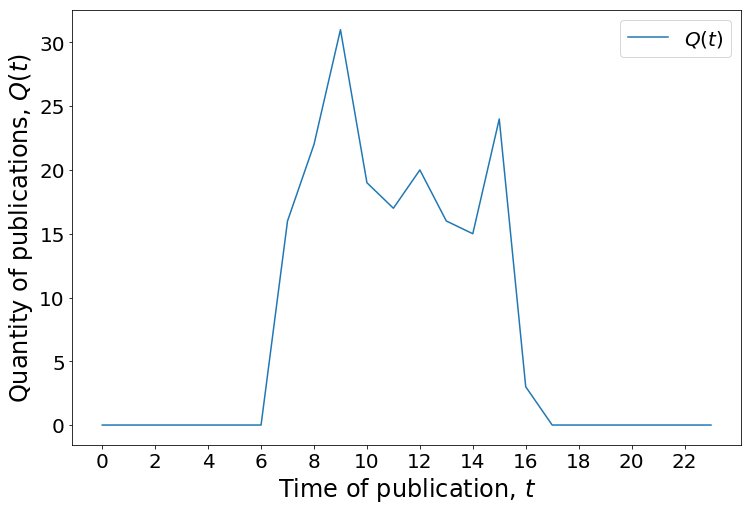

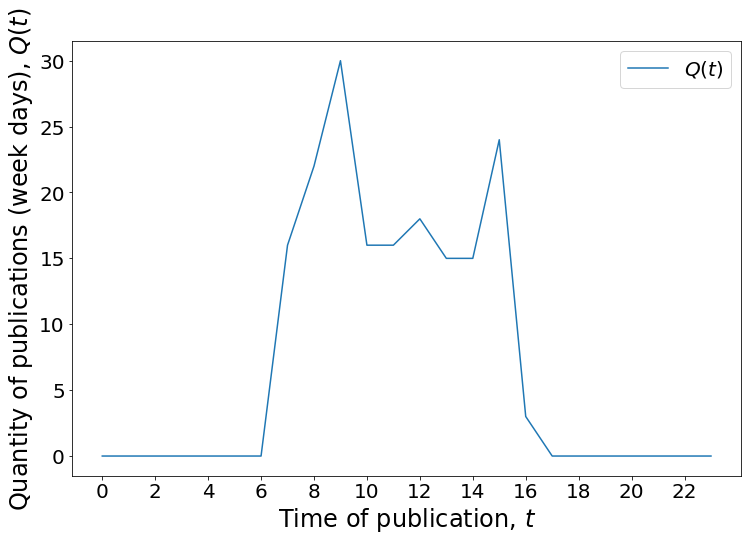

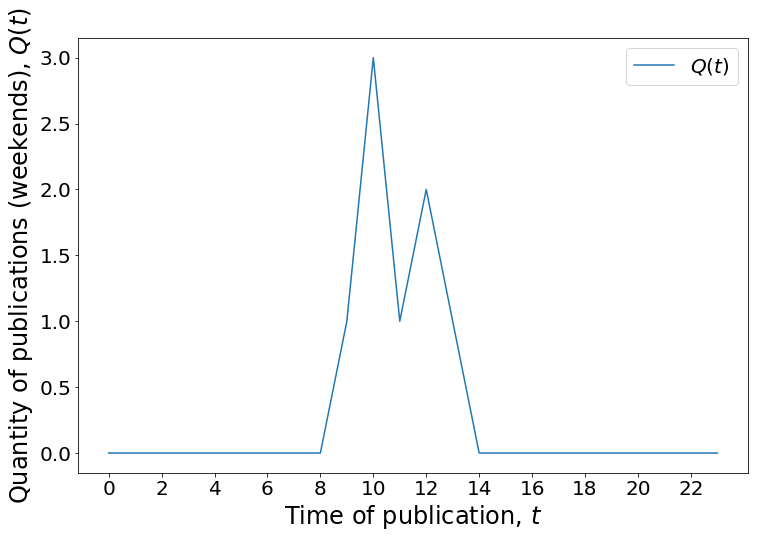

In [75]:
arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications, $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour_bud, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications (week days), $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

arg = np.array([ k for k in range(24)])
plt.figure(figsize=(12,8))
plt.plot(arg,pub_hour_week, label=r"$Q(t)$")
plt.xlabel("Time of publication, $t$", fontsize=24)
plt.ylabel("Quantity of publications (weekends), $Q(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.xticks(np.arange(min(arg), max(arg)+1, 2.0))
plt.show()

* Первые два графика мало чем отличаются, что нормально, учитывая, что подавляющее большинство публикаций производилось в будние дни. Из них видно, что, больше всего публикаций происходит в десятом, первом и четвертом часу. Также, новости начинают появляться в восьмом часу и прекращаются шестом. Тогда, я бы предложил собирать информацию три раза в день: в десять, два и пять часов. Такая частота сбора позволит всегда иметь достаточно актуальную информацию, с задержкой максимум в четыре часа.
* Учитывая то, что на выходных публикуется в среднем одна новость, я бы предложил собирать информацию один раз в день в два часа, так как не было ни одной статьи за месяц, опубликованной позже. Но если мы боимся узнать о чем-то важном слишком поздно, то можно делать сбор два раза: в одинадцать и два.